# MARKETING EFFECTIVENESS - GRUPO 1

## Importación de las librerías

### import pandas as pd
import numpy as np

from pandas import Series, DataFrame

# Training and test spliting
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing

# Estimators
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


# Evaluation
from sklearn import metrics
from sklearn.cross_validation import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

# Optimization
from sklearn.grid_search import GridSearchCV

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

from sklearn.feature_selection import SelectKBest, f_classif

%matplotlib inline

# Carga de Datos

In [2]:
df_sample_submission=pd.read_csv('./sample_submission.csv')
df_test_novel=pd.read_csv('test_nolabel.csv')
df_train=pd.read_csv('train.csv')
df_train.head()

,id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,44dc8df9,35,admin.,married,high.school,unknown,no,no,telephone,jul,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,0
1,3f62aa06,52,technician,married,basic.9y,no,no,no,telephone,jun,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,0
2,34bd6148,44,blue-collar,single,basic.9y,no,no,no,cellular,may,...,4,999,1,failure,-1.8,92.893,-46.2,1.244,5099.1,0
3,e1671cba,35,admin.,married,high.school,no,yes,yes,telephone,jun,...,9,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,c20477f0,33,technician,married,university.degree,no,yes,no,cellular,jul,...,7,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0


## Preprocesado de datos

In [3]:
df_test_novel['job'] = pd.get_dummies(df_test_novel['job'])
df_train['job'] = pd.get_dummies(df_train['job'])

df_test_novel['marital'] = pd.get_dummies(df_test_novel['marital'])
df_train['marital'] = pd.get_dummies(df_train['marital'])

df_test_novel['education'] = pd.get_dummies(df_test_novel['education'])
df_train['education'] = pd.get_dummies(df_train['education'])

df_test_novel['default'] = pd.get_dummies(df_test_novel['default'])
df_train['default'] = pd.get_dummies(df_train['default'])

df_test_novel['housing'] = pd.get_dummies(df_test_novel['housing'])
df_train['housing'] = pd.get_dummies(df_train['housing'])

df_test_novel['loan'] = pd.get_dummies(df_test_novel['loan'])
df_train['loan'] = pd.get_dummies(df_train['loan'])

df_test_novel['contact'] = pd.get_dummies(df_test_novel['contact'])
df_train['contact'] = pd.get_dummies(df_train['contact'])

df_test_novel['month'] = pd.get_dummies(df_test_novel['month'])
df_train['month'] = pd.get_dummies(df_train['month'])

df_test_novel['day_of_week'] = pd.get_dummies(df_test_novel['day_of_week'])
df_train['day_of_week'] = pd.get_dummies(df_train['day_of_week'])

df_test_novel['poutcome'] = pd.get_dummies(df_test_novel['poutcome'])
df_train['poutcome'] = pd.get_dummies(df_train['poutcome'])

In [4]:
features=[#'id',
 'age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [5]:
X = df_train[features].values
y = df_train['y'].values

### With K-BEST = 6

/Users/jgc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


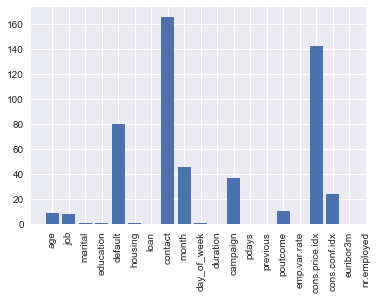

In [6]:
kbest=SelectKBest(f_classif,k=6)
kbest.fit_transform(X, y)

scores = -np.log10(kbest.pvalues_)

X_k = kbest.transform(df_train[features].values)

df_test_novel_transformed = kbest.transform(df_test_novel[features].values)
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_k, y, test_size=0.25, random_state=33)

plt.bar(range(len(features)), scores)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

### No K-BEST

In [7]:
df_test_novel_orig = df_test_novel[features].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

## DecisionTreeClassifier - K-BEST = 6

### Optimization - Grid Search

In [8]:
param_grid = {
    'max_depth': np.arange(1, 10), 
    'max_leaf_nodes': np.arange(2, 30),
    'criterion': ["gini", "entropy"],
    'class_weight': ["balanced", None],
    'max_features': ["auto", "sqrt", "log2", None]
} 

gs_k = GridSearchCV(DecisionTreeClassifier(), param_grid)

gs_k.fit(X_train_k, y_train_k)
print("Best score: ", gs_k.best_score_)
print("Best params: ", gs_k.best_params_)

Best score:  0.9144836225636491
Best params:  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 24}


### Training

In [10]:
model_k = DecisionTreeClassifier(
    class_weight=gs_k.best_params_["class_weight"], 
    max_leaf_nodes=gs_k.best_params_["max_leaf_nodes"], 
    max_depth=gs_k.best_params_["max_depth"],
    criterion=gs_k.best_params_["criterion"],
    max_features=gs_k.best_params_["max_features"]
)

# model_k.fit(X_train_k, y_train_k) # Training with the train subset
model_k.fit(X_k, y) # Training with the the whole set

print()
print("Cross Val Score: "+str(cross_val_score(model_k, X_test_k, y_test_k)))
print("Model Score: "+str(model_k.score(X_test_k, y_test_k)))


Cross Val Score: [0.90683024 0.91511936 0.91144279]
Model Score: 0.9161047861169448


In [11]:
# RESULT FROM GRID SEARCH:
# Best score:  0.9144836225636491
# Best params:  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 24}

# UNCOMMENT BELOW FOR TRAINING WITHOUT GRID SEARCH

# model_k = DecisionTreeClassifier(class_weight=None,max_leaf_nodes=24,max_depth=6,criterion="entropy",max_features=None)
# model_k.fit(X_train_k, y_train_k) # Training with the train subset
# model_k.fit(X_k, y) # Training with the the whole set
# print("Cross Val Score: "+str(cross_val_score(model_k, X_test_k, y_test_k)))
# print("Model Score: "+str(model_k.score(X_test_k, y_test_k)))

### Realizar predicción para Kaggle

In [12]:
predicted = model_k.predict(df_test_novel_transformed)
output = pd.DataFrame( data={"id":df_test_novel.id, "y":predicted} )
output_order = ['id','y']
output[output_order].to_csv('Labels_k.csv', index=False, quoting=3)
output.head()

,id,y
0,897212bf,0
1,2ad6d4ae,0
2,a193003e,0
3,3f639630,0
4,dfe76b9d,0


## DecisionTreeClassifier - No K-BEST

### Optimization - Grid Search

In [13]:
param_grid = {
    'max_depth': np.arange(1, 10), 
    'max_leaf_nodes': np.arange(2, 30),
    'criterion': ["gini", "entropy"],
    'class_weight': ["balanced", None],
    'max_features': ["auto", "sqrt", "log2", None]
} 

gs = GridSearchCV(DecisionTreeClassifier(), param_grid)

gs.fit(X_train, y_train)
print("Best score: ", gs.best_score_)
print("Best params: ", gs.best_params_)

Best score:  0.9149994473306068
Best params:  {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': 18}


### Training

In [14]:
model = DecisionTreeClassifier(
    class_weight=gs.best_params_["class_weight"], 
    max_leaf_nodes=gs.best_params_["max_leaf_nodes"], 
    max_depth=gs.best_params_["max_depth"],
    criterion=gs.best_params_["criterion"],
    max_features=gs.best_params_["max_features"]
)

# model.fit(X_train, y_train) # Training with the train subset
model.fit(X, y) # Training with the the whole set

print()
print("Cross Val Score: "+str(cross_val_score(model, X_test, y_test)))
print("Model Score: "+str(model.score(X_test, y_test)))


Cross Val Score: [0.90484085 0.9147878  0.91177446]
Model Score: 0.9185365314468885


In [15]:
# RESULT FROM GRID SEARCH:
# Best score:  0.9149994473306068
# Best params:  {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': 18}

# UNCOMMENT BELOW FOR TRAINING WITHOUT GRID SEARCH

# model = DecisionTreeClassifier(class_weight=None,max_leaf_nodes=18,max_depth=5,criterion="gini",max_features=None)
# model.fit(X_train, y_train) # Training with the train subset
# model.fit(X, y) # Training with the the whole set
# print("Cross Val Score: "+str(cross_val_score(model, X_test, y_test)))
# print("Model Score: "+str(model.score(X_test, y_test)))

In [16]:
from sklearn.tree import export_graphviz
import graphviz 

dot_data = export_graphviz(model, 
                            out_file=None, 
                            filled=True, 
                            rounded=True)  
graph = graphviz.Source(dot_data)  
#graph 

### Realizar predicción para Kaggle

In [17]:
predicted = model.predict(df_test_novel_orig)
output = pd.DataFrame( data={"id":df_test_novel.id, "y":predicted} )
output_order = ['id','y']
output[output_order].to_csv('Labels.csv', index=False, quoting=3)
output.head()

,id,y
0,897212bf,0
1,2ad6d4ae,0
2,a193003e,0
3,3f639630,0
4,dfe76b9d,0
